In [1]:
import itertools
import math
from collections import Counter
from operator import itemgetter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from networkx.algorithms.community import girvan_newman

import networkx as nx 

In [2]:
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

In [4]:
# Load all sheets from an Excel file
sheets = pd.read_excel('Data_ToDraw_networkX_all_5A.xlsx', sheet_name=None,     
                       usecols=['distance','residue_x', 'residue_y'])

In [3]:
# Load all sheets from an Excel file
sheets = pd.read_excel('Data_ToDraw_networkX_all_5A.xlsx', sheet_name=None,     
                       usecols=['distance','residue_x', 'residue_y'])
betCent_result = {}
# Loop over all sheets and print the data
for sheet_name, sheet_data in sheets.items():
    G=nx.Graph()
    for i in range(len(sheet_data)):
        node=sheet_data.loc[i,:][1] # first column as node
        next_node=sheet_data.loc[i,:][2]# second column as  node
        weight=sheet_data.loc[i,:][0] # last column as edge cost/weight
        G.add_weighted_edges_from([(node,next_node,weight)])

    # compute the edge betweenness centrality of the graph
    betCent = nx.edge_betweenness_centrality(G, normalized=True, weight = True)
    # create betCent numpy array with edge and node information
    node_to_index = {node: i for i, node in enumerate(G.nodes())}
    betCent_array = np.zeros((len(betCent), 3), dtype=object)
    for i, (u, v) in enumerate(betCent.keys()):
        u_index = node_to_index[u]
        v_index = node_to_index[v]
        betCent_value =betCent[(u, v)]
        betCent_array[i] = [u, v, betCent_value]
    betCent_result[sheet_name] = betCent_array 

计算node_betweenness并将其输出到excel中

In [ ]:
with pd.ExcelWriter("node_betweenness.xlsx") as writer:
    for sheet_name, sheet_data in sheets.items():
        G=nx.Graph()
        for i in range(len(sheet_data)):
            node=sheet_data.loc[i,:][1] # first column as node
            next_node=sheet_data.loc[i,:][2]# second column as  node
            weight=sheet_data.loc[i,:][0] # last column as edge cost/weight
            G.add_weighted_edges_from([(node,next_node,weight)])

        # Calculate node betweenness centrality
        node_betweenness = nx.betweenness_centrality(G)

        df = pd.DataFrame({'Node': list(node_betweenness.keys()),   
                           'Betweenness Centrality': list(node_betweenness.values())})
        
        df.to_excel(writer, sheet_name = sheet_name, index=False)


In [4]:
def creat_betCent_array(df):
    G=nx.Graph()
    for i in range(len(df)):
        node=df.loc[i,:][1] # first column as node
        next_node=df.loc[i,:][2]# second column as  node
        weight=df.loc[i,:][0] # last column as edge cost/weight
        G.add_weighted_edges_from([(node,next_node,weight)])

    # compute the edge betweenness centrality of the graph
    betCent = nx.edge_betweenness_centrality(G, normalized=True, weight = True)
    # create betCent numpy array with edge and node information
    node_to_index = {node: i for i, node in enumerate(G.nodes())}
    betCent_array = np.zeros((len(betCent), 3), dtype=object)
    for i, (u, v) in enumerate(betCent.keys()):
        u_index = node_to_index[u]
        v_index = node_to_index[v]
        betCent_value =betCent[(u, v)]
        betCent_array[i] = [u, v, betCent_value]

In [5]:
def cal_community_dis(com1, com2, ebc_array, df_group_dic):
    com_dis = []
    for line in ebc_array:
        if (line[0] in df_group_dic[com1]) and (line[1] in df_group_dic[com2]):
            com_dis.append([line[0],line[1],line[2]])
        elif (line[0] in df_group_dic[com1]) and (line[1] in df_group_dic[com2]):
            com_dis.append([line[0],line[1],line[2]])
        else:
            pass
    return com_dis

def cal_weight(com_dis): 
    if com_dis != []:
        com_pd = pd.DataFrame(com_dis)
        weight = com_pd.iloc[:, 2].sum()
    else:
        weight = 0
    return weight

In [6]:
def CreatCommunityDF(array_df, group_dic):
    num_com = len(group_dic) # num_com指社区个数
    list_com = list(itertools.combinations(range(num_com), 2))
    com = pd.DataFrame(list_com, columns= ["com1", 'com2'])
    com_pd = com.iloc[:,:2]+1
    wg = []
    for i in list(itertools.combinations(range(num_com), 2)):
        dis = cal_community_dis(i[0], i[1], array_df, group_dic)
        weight = cal_weight(dis)
        wg.append(weight)
    com_weight = pd.concat([com_pd, pd.DataFrame(wg, columns= ["weight"])], 
        axis= 1)
    com_weight = com_weight.drop(com_weight[com_weight.weight == 0].index)
    com_weight["com_str1"] =[ 'community % i' % i for i in com_weight["com1"]]
    com_weight["com_str2"] =[ 'community % i' % i for i in com_weight["com2"]]
    return com_weight

In [7]:
# Load all sheets from an Excel file
sheets_q = pd.read_excel('modularity_community_all.xlsx', sheet_name=None,     
                       skiprows =1, header=None)

In [8]:
name = list(sheets_q.keys())

In [9]:
# 社区之间的连接数据
community_draw = {}
for sheet_name_q, sheet_data_q in sheets_q.items():
    dic_group = sheet_data_q.to_dict(orient='list')
    for sheet_name, sheet_data in sheets.items():
        community_draw[sheet_name_q] = CreatCommunityDF(betCent_result[sheet_name],     
                                                        dic_group)

In [10]:
# 将社区之间的连接数据输出到excel
with pd.ExcelWriter("community_all_spheres.xlsx") as writer:
    for i in name:
        sort_com = community_draw[i].sort_values(by="weight",ascending=False)
        sort_com.to_excel(writer, sheet_name= i + '_sort', index= None)

In [34]:
def DrawNetwork(com_weight, group, save_name, asterisk):
    g = nx.Graph()
    for i in range(len(com_weight)):
        node=com_weight.iloc[i,:][0] 
        next_node=com_weight.iloc[i,:][1]
        weight=com_weight.iloc[i,:][2]
        g.add_weighted_edges_from([(node,next_node,weight)])
    
    custom_labels = {node: f"{node}{asterisk}" for node in g.nodes()}
    # 可视化
    fig, ax = plt.subplots(figsize=(10, 10))
    shells = [[1], [i for i in range(2,len(group.columns)+1)]]
    pos = nx.shell_layout(g, shells) 
    #pos = nx.shell_layout(g) 
    nx.draw_networkx_nodes(
        g, pos, 
        nodelist=g.nodes(), 
        node_size=[(group[index-1].count()) * 30 for index in g.nodes()], 
        #node_color= range(len(group.columns)),
        node_color= range(len(g.nodes())),
        cmap=plt.colormaps["tab20c"], 
        edgecolors= 'k'
        )
    nx.draw_networkx_edges(
        g, pos, alpha=0.9, 
        edgelist=[(u, v, d['weight']) for u, v, d in g.edges(data=True)],
        width= [float(d['weight'] * 40) for (u,v,d) in g.edges(data=True)],
        edge_color='black'
        )
    nx.draw_networkx_labels(
        g, pos, font_size=18, font_color="black", labels=custom_labels 
        )
    plt.axis('off')
    plt.savefig(save_name + "_community_graph.tif", dpi=300, bbox_inches='tight')
    plt.show()

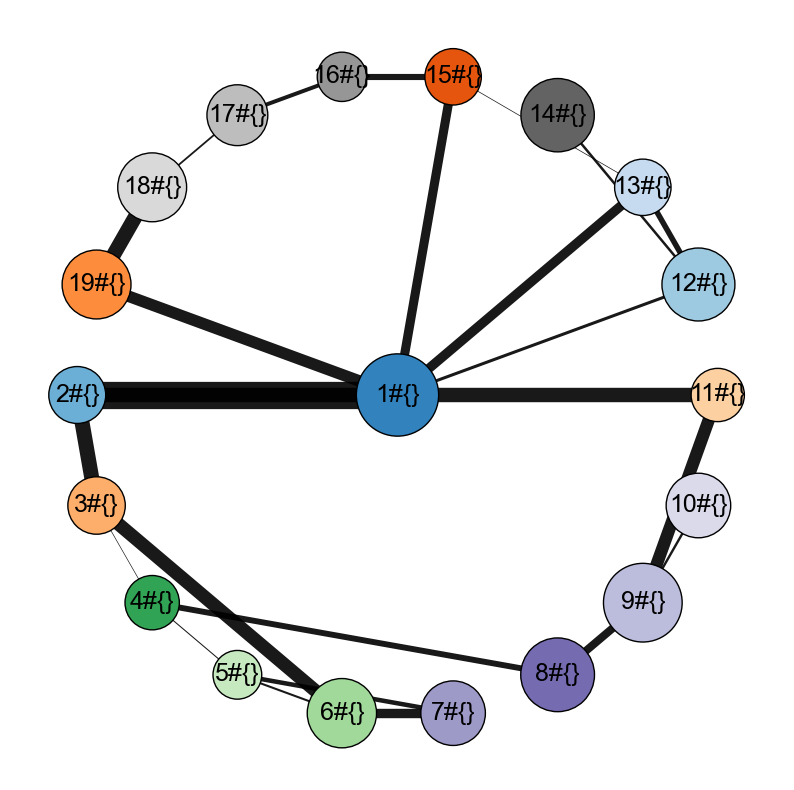

In [32]:
fig_4zt0 = DrawNetwork(community_draw['com_4zt0'], sheets_q['com_4zt0'], 
                       "4zt0", "")

fruchterman_reingold_layout 每次刷新得到的布局都不一样，多次更新寻找最合适的

In [273]:

# 绘制社区节点图
g_6ifo_rep2 = nx.Graph()
for i in range(len(community_draw['com_6ifo_rep2'])):
    node=community_draw['com_6ifo_rep2'].iloc[i,:][0] 
    next_node=community_draw['com_6ifo_rep2'].iloc[i,:][1] 
    weight=community_draw['com_6ifo_rep2'].iloc[i,:][2]
    g_6ifo_rep2.add_weighted_edges_from([(node,next_node,weight)])
custom_labels = {node: f"{node}ʼʼʼ" for node in g_6ifo_rep2.nodes()}


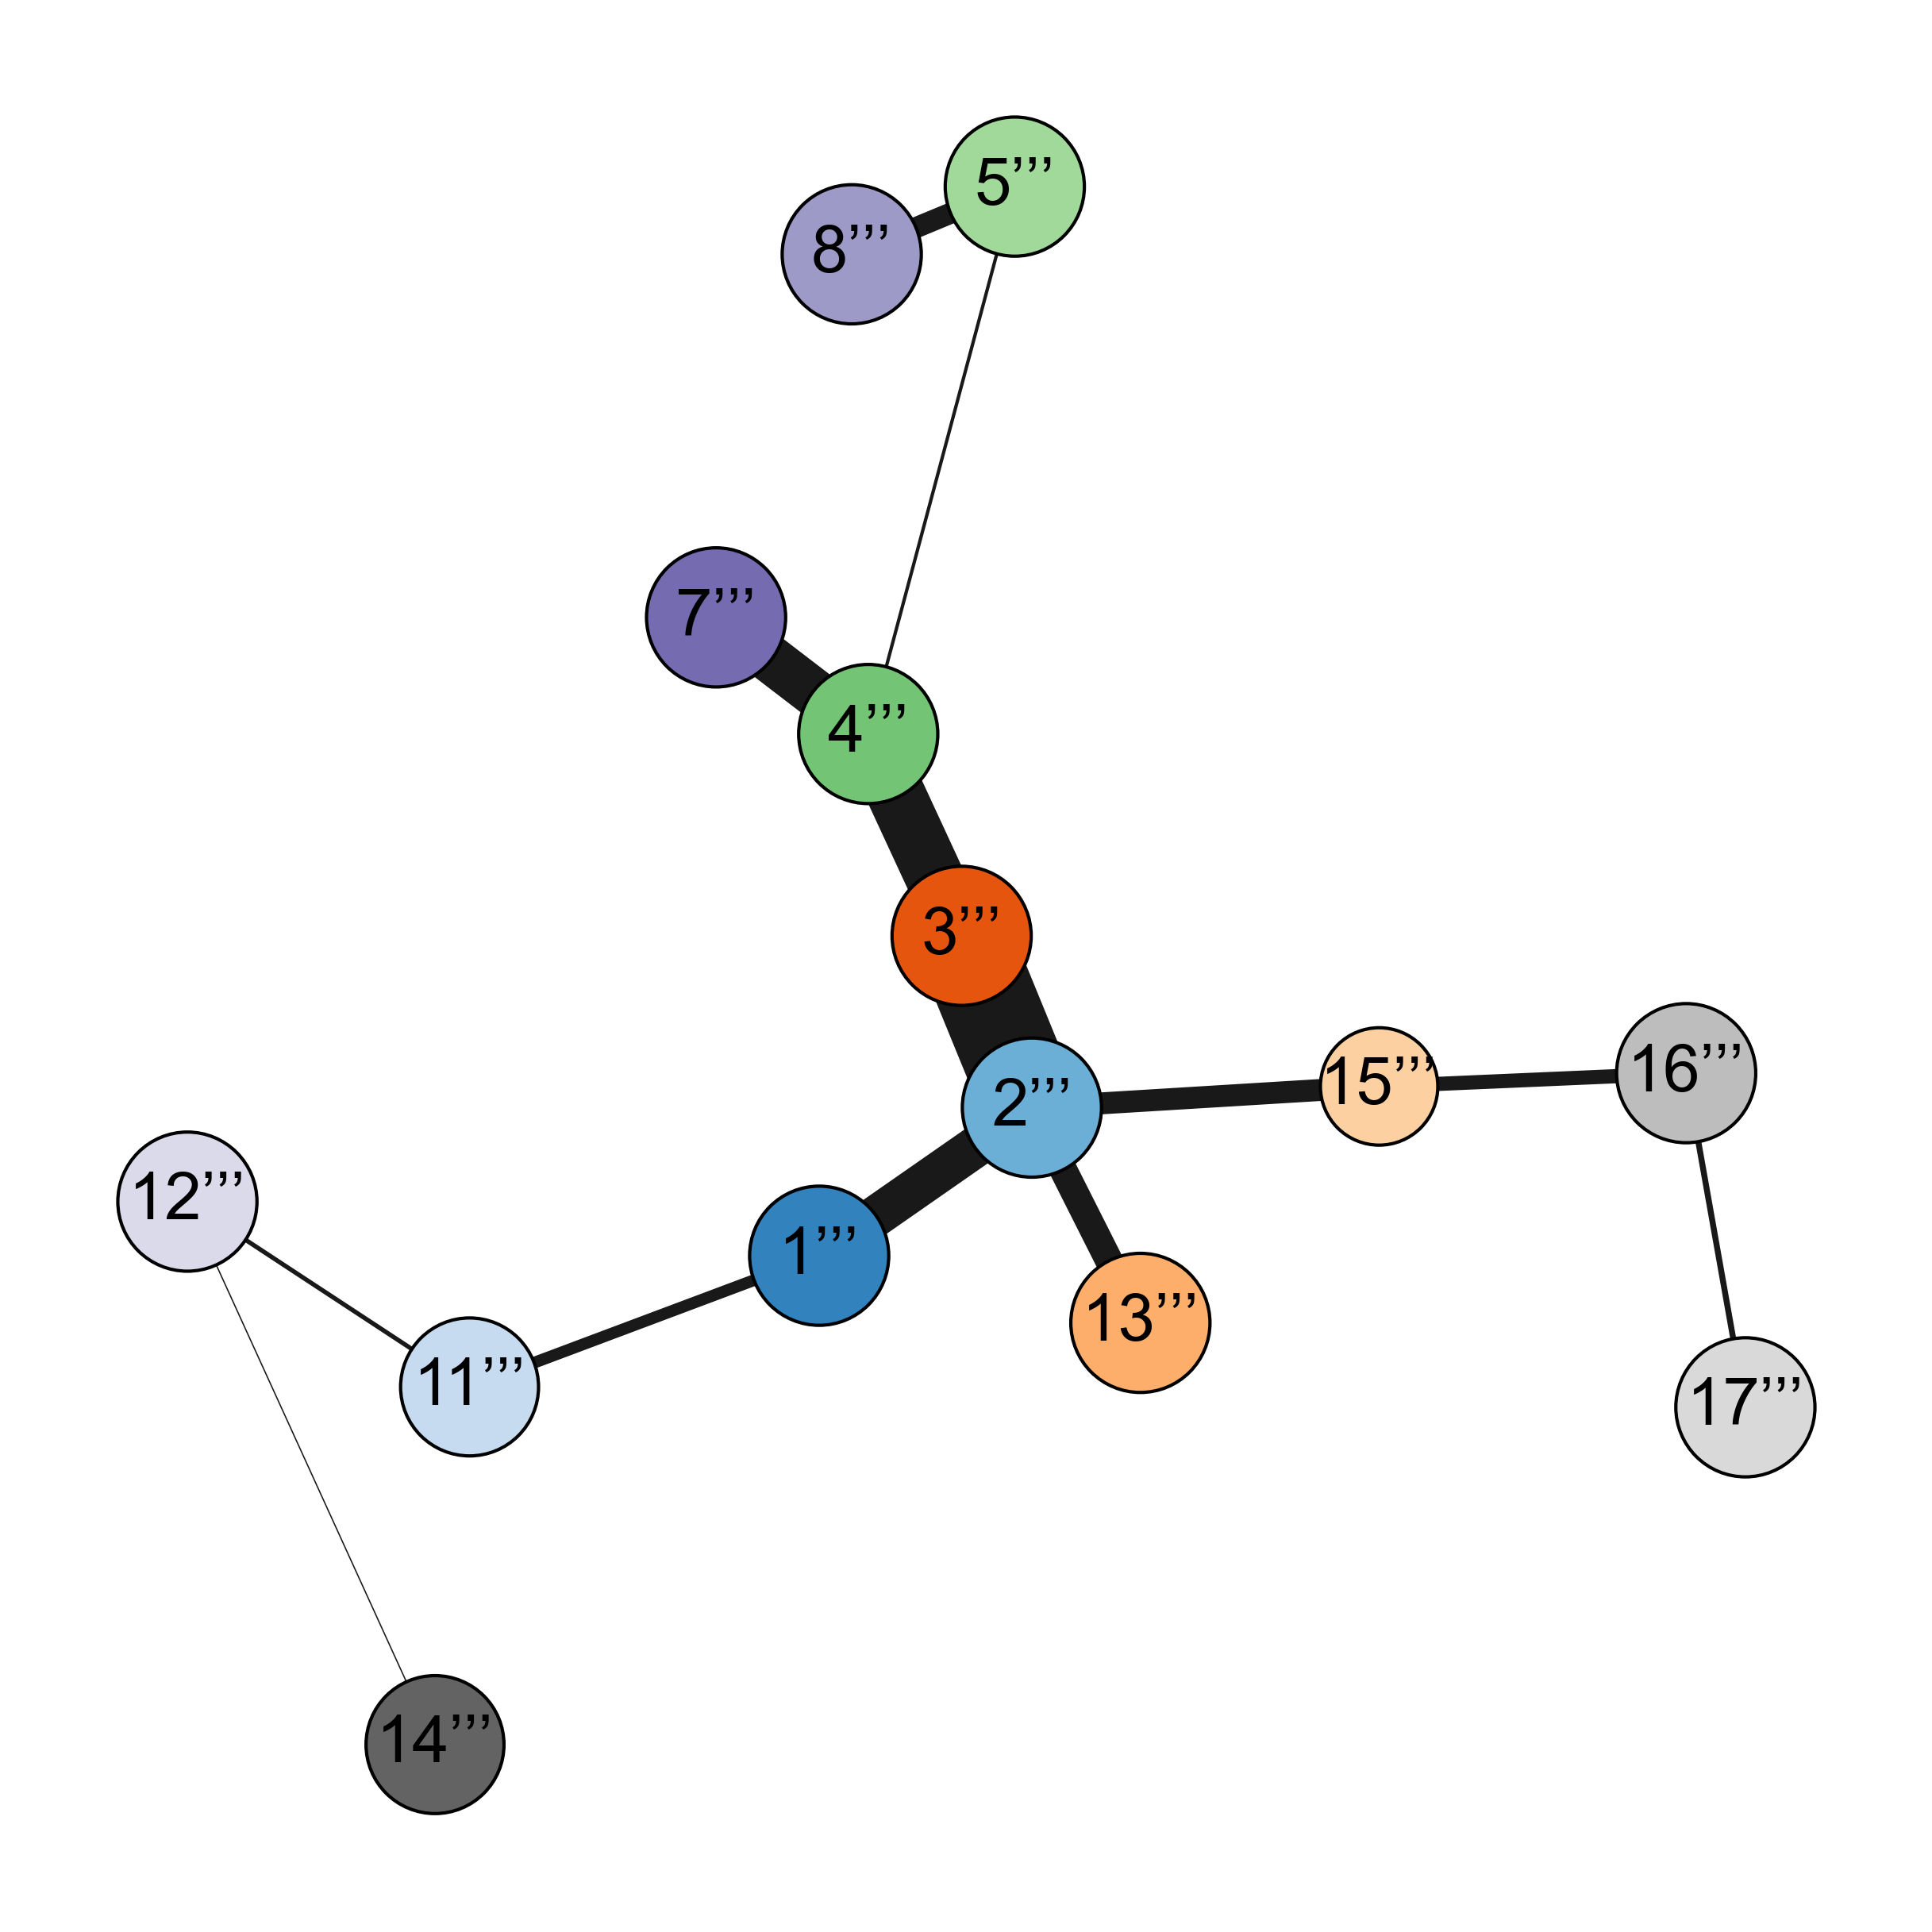

In [300]:

fig = plt.figure(dpi=300, figsize=(8, 8), constrained_layout=True)
pos = nx.fruchterman_reingold_layout(g_6ifo_rep2, weight='weight')

nx.draw_networkx_nodes(
        g_6ifo_rep2, pos, 
        nodelist=g_6ifo_rep2.nodes(), 
        node_size=[(sheets_q['com_6ifo_rep2'][index-1].count()) * 30 for index in g_6ifo_rep2.nodes()], 
        #node_color= range(len(sheets_q[name].columns)),
        node_color= range(len(g_6ifo_rep2.nodes())),
        #cmap=plt.cm.get_cmap("viridis"),
        cmap=plt.cm.get_cmap("tab20c"), 
        edgecolors= 'k'
        )
nx.draw_networkx_edges(
        g_6ifo_rep2, pos, alpha=0.9, 
        edgelist=[(u, v, d['weight']) for u, v, d in g_6ifo_rep2.edges(data=True)],
        width= [float(d['weight'] * 60) for (u,v,d) in g_6ifo_rep2.edges(data=True)],
        edge_color='black'
        )
nx.draw_networkx_labels(
        g_6ifo_rep2, pos, font_size=20, font_color="black", labels=custom_labels
        )
plt.axis('off')
plt.savefig("6ifo_rep2_finalUse_community_graph_.tif", dpi=300, bbox_inches='tight')
plt.show(block=False)


将4个社区连通图合并在一起

In [11]:
namelist = ['com_4zt0', 'com_4un3', 'com_5xbl', 'com_6ifo']

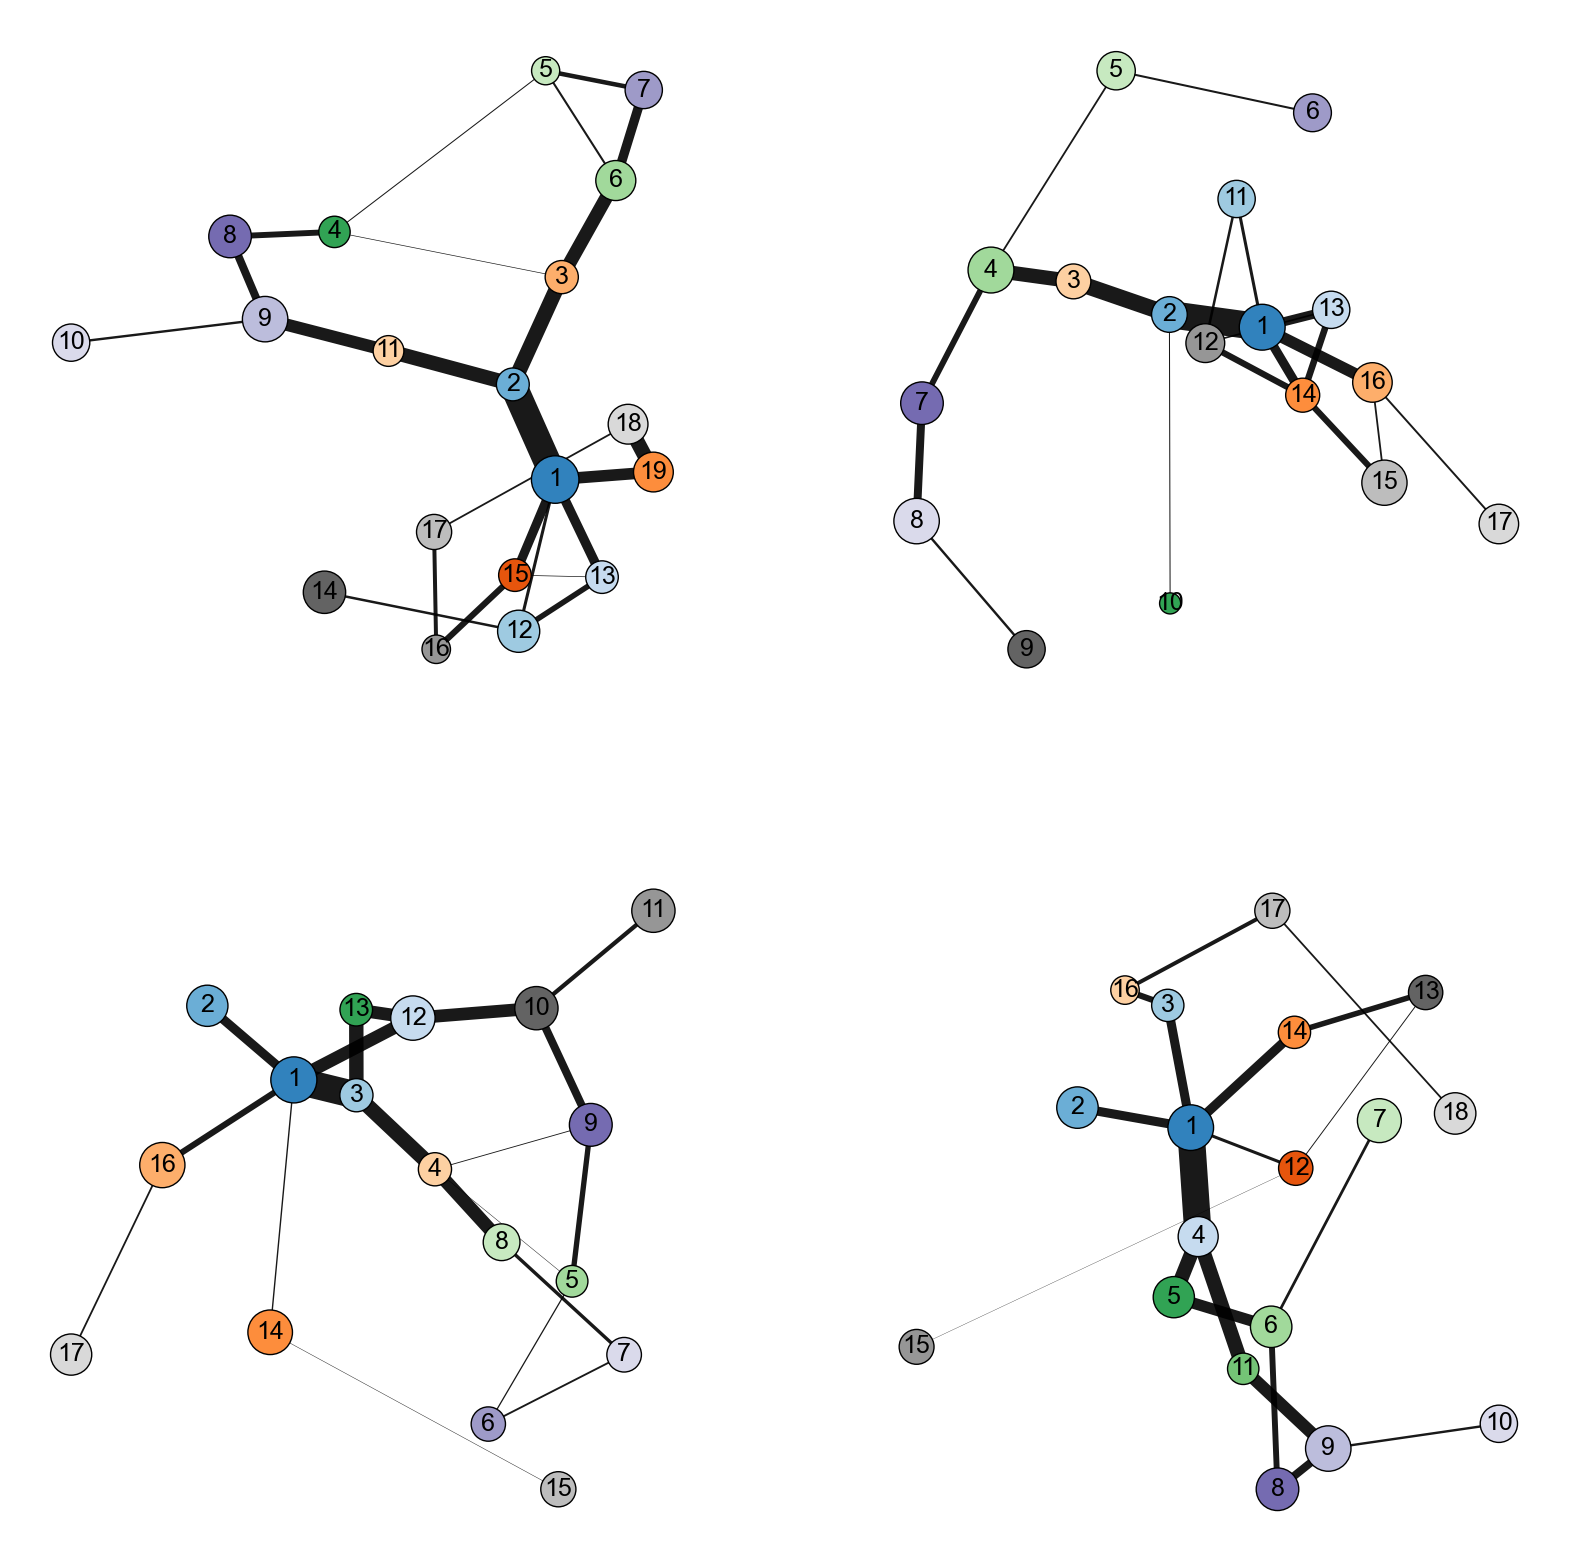

In [23]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 20))
axes = [ax1, ax2, ax3, ax4]
for name, ax in zip(namelist, axes):
    g = nx.Graph()
    for i in range(len(community_draw[name])):
        node=community_draw[name].iloc[i,:][0] 
        next_node=community_draw[name].iloc[i,:][1]
        weight=community_draw[name].iloc[i,:][2]
        g.add_weighted_edges_from([(node,next_node,weight)])

    #shells = [[1], [i for i in range(2,len(sheets_q[name].columns)+1)]]
    pos = nx.fruchterman_reingold_layout(g)
    #pos = nx.shell_layout(g) 
    nx.draw_networkx_nodes(
        g, pos, 
        nodelist=g.nodes(), 
        node_size=[(sheets_q[name][index-1].count()) * 10 for index in g.nodes()], 
        #node_color= range(len(sheets_q[name].columns)),
        node_color= range(len(g.nodes())),
        cmap=plt.colormaps["tab20c"], 
        edgecolors= 'k', ax = ax,
        )
    nx.draw_networkx_edges(
        g, pos, alpha=0.9, 
        edgelist=[(u, v, d['weight']) for u, v, d in g.edges(data=True)],
        width= [float(d['weight'] * 40) for (u,v,d) in g.edges(data=True)],
        edge_color='black', ax = ax,
        )
    nx.draw_networkx_labels(
        g, pos, font_size=18, font_color="black", ax = ax,
        )
    ax.axis('off')
#plt.savefig("finalUse_community_graph.tif", dpi=300, bbox_inches='tight')
plt.show(block=False)

给每个节点添加大小并生成GML格式文件  (Gephi绘图)

In [ ]:

for node in g.nodes():
    # Set the node size attribute based on a function of the node degree or other relevant metric
    g.nodes[node]['size'] = str(group_5A[node -1].count() * 10)
    # convert integer node labels to strings
mapping = {n: str(n) for n in g.nodes()}
g = nx.relabel_nodes(g, mapping)

# write the graph to a GML file
nx.write_gml(g, '5xbl_graph_with_size.gml')